In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import numpy as np
%matplotlib inline
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json
from orbsim.r3b_2d import UNIT_TIME
from orbsim.r3b_2d.analyticals import *
from orbsim.r3b_2d.simulators import launch_sim
from orbsim.plotting import orbitplot2d, orbitplot_non_inertial
import time
from random import shuffle
from numba import jit
import math
from math import pi

pi8=pi/8
pi4=pi/4
pi2=pi/2

In [12]:
psis=[]
paths=[]
title="long_leto_lyapunov"
N=5
for i in range(N):
    psi = [3.794182930145708, 0.023901745288554, 3.090702702702703+i/1e3]
    path = launch_sim(psi,max_iter=1e7, duration=200/UNIT_TIME)
    psis.append(psi)
    paths.append(path)


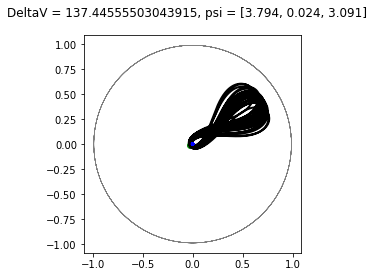

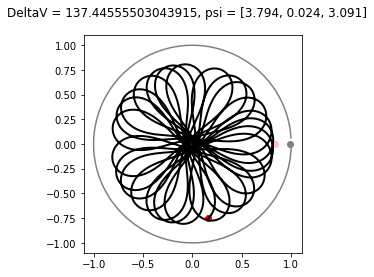

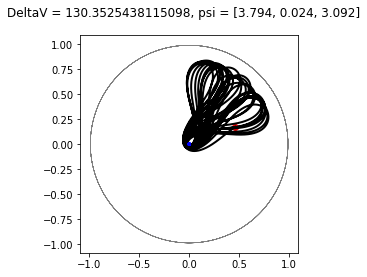

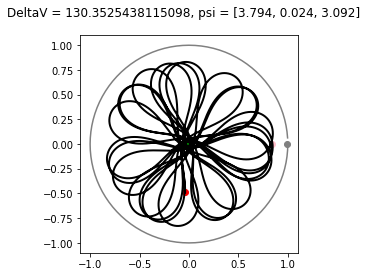

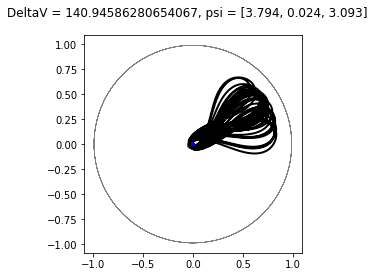

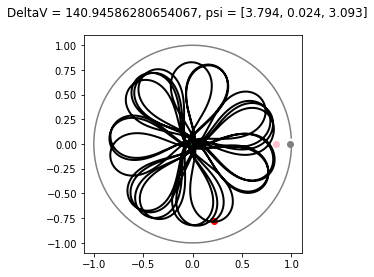

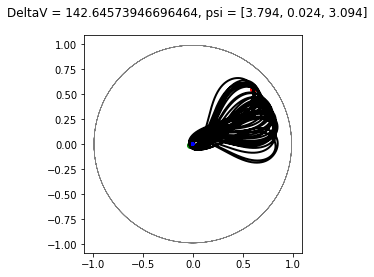

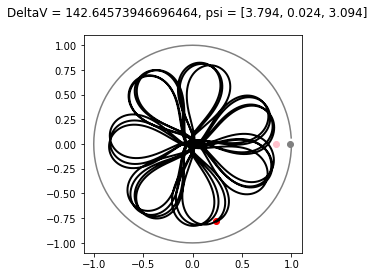

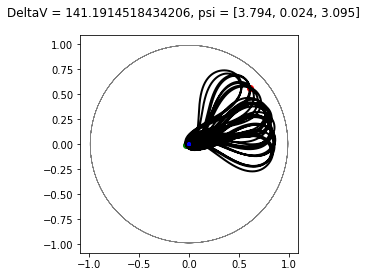

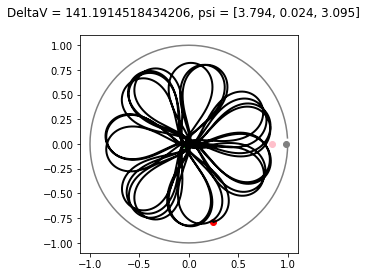

In [13]:
for i in range(len(paths)):
    orbitplot2d(paths[i],psis[i],title=f"{title}_{i}")
    orbitplot_non_inertial(paths[i],psis[i],title=f"{title}_{i}")

In [7]:
lyaps=[]
for a in range(N):
    for b in range(N):
        if a==b:
            continue
        lyap=[]
        _a=np.array(paths[a][1]).T
        _b=np.array(paths[b][1]).T
        xas=_a[0]
        yas=_a[1]
        xbs=_b[0]
        ybs=_b[1]
        hs=(_a[4],_b[4])        
        
        ts=[None,None]
        for l in range(len(hs)):
            idxs=[]
            tally=0
            for i in range(len(hs[l])):
                h=hs[l][i]
                tally+=h
                if tally>=1.5e-6:
                    idxs.append(i)
                    tally=0
            ts[l]=idxs
            
        min_ts=min(ts,key=len)
        for i in range(len(min_ts)):
            idx=min_ts[i]
            lyap.append(sqrt((xas[idx]-xbs[idx])**2+(yas[idx]-ybs[idx])**2))
        lyaps.append(lyap)
print(len(lyaps))

20


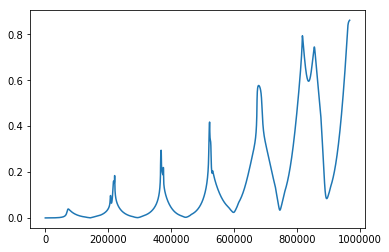

In [8]:
plt.plot(range(len(lyaps[5])),lyaps[5])

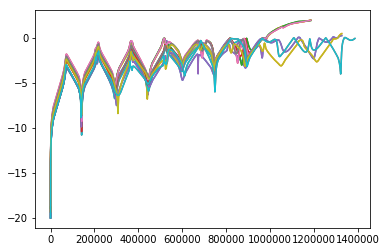

In [9]:
for i in range(len(lyaps)):
    lyap=lyaps[i][1:]
    loglyap=[np.log(x) for x in lyap]
    plt.plot(range(len(loglyap)),loglyap)

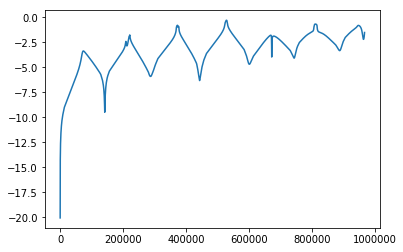

In [10]:
    lyap=lyaps[0][1:]
    loglyap=[np.log(x) for x in lyap]
    plt.plot(range(len(loglyap)),loglyap)

In [10]:
derp = np.array(paths[0][1]).T
hderp=derp[4]
hderp

array([1.00000000e-06, 4.41545159e-08, 4.41540016e-08, ...,
       3.58244599e-05, 3.58244629e-05, 3.58244648e-05])

In [11]:
csum=np.cumsum(hderp)
csum

array([1.00000000e-06, 1.04415452e-06, 1.08830852e-06, ...,
       2.29980477e+01, 2.29980835e+01, 2.29981193e+01])

In [29]:
idxs=[]
tally=0
for i in range(len(hderp)):
    h=hderp[i]
    tally+=h
    if tally>=1.5e-6:
        idxs.append(i)
        tally=0
len(idxs)

1185623

In [13]:
len(csum)

1619475

In [17]:
np.mean(hderp)

1.4200972119633385e-05